In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 


In [2]:



sys.path.append("../../LPP/LPP_package/")

from lpp_package.data.language_data import LanguageData
from lpp_package.data.preprocess import preprocess_data
from lpp_package.models.regression_estimators import RegressionEstimators
from lpp_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results





In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/LPP/Models"),
    "results_path": Path("/home/soroosh/Programmes/LPP/Results"),
    "figures_path": Path("/home/soroosh/Programmes/LPP/Figures"),
    "params_path": Path("/home/soroosh/Programmes/LPP/Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="lpp_all_fix_demo"

estimator_name = "rf_reg"
to_shuffle = True
to_exclude_at_risk = 0
pp = "mm"


In [5]:

specifier = data_name + "-" + estimator_name + "--shuffled:" + str(to_shuffle)



In [6]:


configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'lpp_all_fix_demo-rf_reg--shuffled:True'

## Load Data

In [8]:


lpp = LanguageData(path="../../LPP/datasets_LPP/",
                   n_repeats=5, 
                   data_name=data_name)




In [9]:
# Determine which dataset to use, e.g. demo dataset
# alone or concatenation of demo and IA_report, for instance.
if data_name == "lpp_ru_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_ru_fix_demo_datasets()  # demos and fixation

    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration', 'motiv', 'IQ',
                                  'Age', 'Sex', 'Target_Ave', 'Target_Label']]
    c_features = ['Sex']
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_all_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_all_fix_demo_datasets()  # demos and fixation

    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration', 'motiv', 'IQ',
                                  'Age', 'Sex', 'Target_Ave', 'Target_Label']]
    c_features = ['Sex']
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_ru_fix":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_ru_fix_demo_datasets()  # demos and fixation
    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration',
                                  'Target_Ave', 'Target_Label']] # fixation data only
    c_features = []
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

elif data_name == "lpp_all_fix":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    demo = lpp.get_all_fix_demo_datasets()  # demos and fixation
    df_data_to_use = demo.loc[:, ['Fix_X', 'Fix_Y', 'Fix_Duration',
                                  'Target_Ave', 'Target_Label']] # fixation data only
    c_features = []
    indicators = ['SubjectID']
    targets = ['Target_Ave', 'Target_Label']

# Later we should add other language getters or
#   at-least one more getter for whole of the nations under consideration.
else:
    print("data_name argument:", data_name)
    assert False, "Ill-defined data_name argument. Refer to help of data_name argument for more."


Loading Fix_Demo data from csv: 
  (1080285, 21)
 


In [10]:

df_data_to_use.head()



,Fix_X,Fix_Y,Fix_Duration,motiv,IQ,Age,Sex,Target_Ave,Target_Label
0,103,123,48,3.8,6,19,0,3.946772,4
1,366,152,96,3.8,6,19,0,3.946772,4
2,250,135,117,3.8,6,19,0,3.946772,4
3,175,123,264,3.8,6,19,0,3.946772,4
4,226,119,155,3.8,6,19,0,3.946772,4


In [11]:

x_org, y_org = lpp.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)


In [ ]:


x_org



In [13]:



y_org



,Target_Ave,Target_Label
0,3.946772,4
1,3.946772,4
2,3.946772,4
3,3.946772,4
4,3.946772,4
...,...,...
1080280,2.587294,3
1080281,2.587294,3
1080282,2.587294,3
1080283,2.587294,3


In [14]:


print("x_org:", x_org.shape, "\n", x_org.head())

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    from lpp_package.models.regression_estimators import RegressionEstimators
    y = y_org.Target_Ave.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    from lpp_package.models.classification_estimators import ClassificationEstimators
    y = y_org.Target_Label.values

elif estimator_name.split("_")[-1] == "clu":
    learning_method = "clustering"
    from lpp_package.models.clustering_estimators import ClusteringEstimators

    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "ad":
    learning_method = "abnormality_detection"
    from lpp_package.models.abnormality_estimators import AbnormalityEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"

if to_shuffle == 1:
    to_shuffle = True
    group = learning_method + "-" + "shuffled"
else:
    to_shuffle = False
    group = learning_method + "-" + "not-shuffled"


x_org: (1080285, 8) 
    Fix_Duration  Sex_0  IQ  Fix_Y  Fix_X  Sex_1  Age  motiv
0            48   True   6    123    103  False   19    3.8
1            96   True   6    152    366  False   19    3.8
2           117   True   6    135    250  False   19    3.8
3           264   True   6    123    175  False   19    3.8
4           155   True   6    119    226  False   19    3.8


In [15]:
y

array([3.947, 3.947, 3.947, ..., 2.587, 2.587, 2.587])

In [16]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (1080285, 8)


In [17]:


x




array([[0.007748020885969345, 1.0, 0.45454545454545453, ..., 0.0,
        0.09090909090909091, 0.7272727272727271],
       [0.015832912245241703, 1.0, 0.45454545454545453, ..., 0.0,
        0.09090909090909091, 0.7272727272727271],
       [0.019370052214923363, 1.0, 0.45454545454545453, ..., 0.0,
        0.09090909090909091, 0.7272727272727271],
       ...,
       [0.030149907360619843, 1.0, 0.7272727272727273, ..., 0.0,
        0.3181818181818182, 0.5909090909090908],
       [0.02206501600134748, 1.0, 0.7272727272727273, ..., 0.0,
        0.3181818181818182, 0.5909090909090908],
       [0.01886474650496884, 1.0, 0.7272727272727273, ..., 0.0,
        0.3181818181818182, 0.5909090909090908]], dtype=object)

In [21]:

np.random.seed(43)
data = lpp.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Target_Label.values,
        to_shuffle=to_shuffle,
        n_splits=configs.n_repeats
    )



In [22]:

data.keys()


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

## Load the tuned parameters OR weights

In [23]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params


# dc_all_e.csv-knn_reg--shuffled:True


OrderedDict([('min_samples_leaf', 7),
             ('min_samples_split', 3),
             ('n_estimators', 459)])

In [36]:


mdl = sklearn.ensemble. (
   **tuned_params, n_jobs=4, 
)

mdl


RandomForestRegressor(min_samples_leaf=7, min_samples_split=3, n_estimators=459,
                      n_jobs=4)

In [37]:


specifier



'lpp_all_fix_demo-rf_reg--shuffled:True'

In [38]:

k_ = "4"
x_train = data[k_]["x_train"]
x_test = data[k_]["x_test"]
y_train = data[k_]["y_train"]
y_test = data[k_]["y_test"]





In [39]:


y_test




array([3.947, 3.947, 3.947, ..., 2.587, 2.587, 2.587])

In [40]:


# class_names = ['Control', 'At-risk', 'Dyslexic']



In [41]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )


r2, mae = [], []

for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    
    tmp =  sklearn.metrics.r2_score(y_test_, y_pred_)
    r2.append(tmp)
    
    tmp2 = sklearn.metrics.mean_absolute_error(y_test_, y_pred_,)
    mae.append(tmp2)
  
    print(
        f"R2: {tmp: .3f}",
        
        f"MAE: {tmp2: .3f}"
    )




R2:  0.899 MAE:  0.066
R2:  0.899 MAE:  0.065
R2:  0.900 MAE:  0.065
R2:  0.899 MAE:  0.065
R2:  0.898 MAE:  0.066
R2:  0.899 MAE:  0.066
R2:  0.900 MAE:  0.065
R2:  0.901 MAE:  0.065
R2:  0.899 MAE:  0.066
R2:  0.899 MAE:  0.066


In [42]:

results[i]["y_pred"]
    


array([3.947, 3.947, 3.947, ..., 2.799, 2.715, 2.713])

In [43]:


y_test_




array([3.947, 3.947, 3.947, ..., 2.587, 2.587, 2.587])

In [44]:

r2 = np.asarray(r2)
r2.mean(), r2.std()




(0.8992568091742529, 0.0008606200588455428)

In [45]:


mae = np.asarray(mae)
mae.mean(), mae.std()




(0.06543508501566606, 0.0003358787308016469)

In [46]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)




   mae     rmse  	 mrae 	 r2_score  	 meape  	 jsd 
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.065 0.000 0.184 0.001 0.020 0.000 0.899 0.001 0.018 0.005 0.019 0.000


In [47]:


mdl.fit(x_train, y_train)




RandomForestRegressor(min_samples_leaf=7, min_samples_split=3, n_estimators=459,
                      n_jobs=4)

In [48]:

y_test[5:10:]



array([3.947, 3.947, 3.947, 3.947, 3.947])

In [49]:


mdl.predict(x_test[5:10:, :])





array([3.947, 3.947, 3.947, 3.947, 3.947])

In [50]:

sklearn.metrics.r2_score(y_test, 
                         mdl.predict(x_test)
                        )



0.898783224442766

In [51]:


y_test




array([3.947, 3.947, 3.947, ..., 2.587, 2.587, 2.587])

In [52]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [53]:

idx_0 = np.where(y_train==0.)[0]
idx_1 = np.where(y_train==1.)[0]
idx_2 = np.where(y_train==2.)[0]
idx_3 = np.where(y_train==3.)[0]



In [58]:


background = shap.sample(x_train, 500) # data to train both explainers on




In [59]:


background.shape


(500, 8)

In [ ]:



explainer = shap.KernelExplainer(
    model=mdl.predict, 
    data=background,
    feature_names=list(x_org.columns), 
)

shap_values = explainer.shap_values(x_test,)




Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/108029 [00:00<?, ?it/s]

In [86]:



print("Shap values are determined!")



Shap values are determined!


In [87]:


len(shap_values)


108029

In [88]:


y_test.shape, x_test.shape, len(shap_values), shap_values[0].shape, 




((108029,), (108029, 8), 108029, (8,))

In [89]:

shap_values.shape



(108029, 8)

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [90]:


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RGB_val = 255

color01= (4,87,172)  # (0,255,255)  # Cyan wanted
color04= (244,230,4)  # (255,255,0)  # yellow wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

# End of the creation of the gradient

# newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# shap.summary_plot(shap_values, x_test, color=newcmp)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')




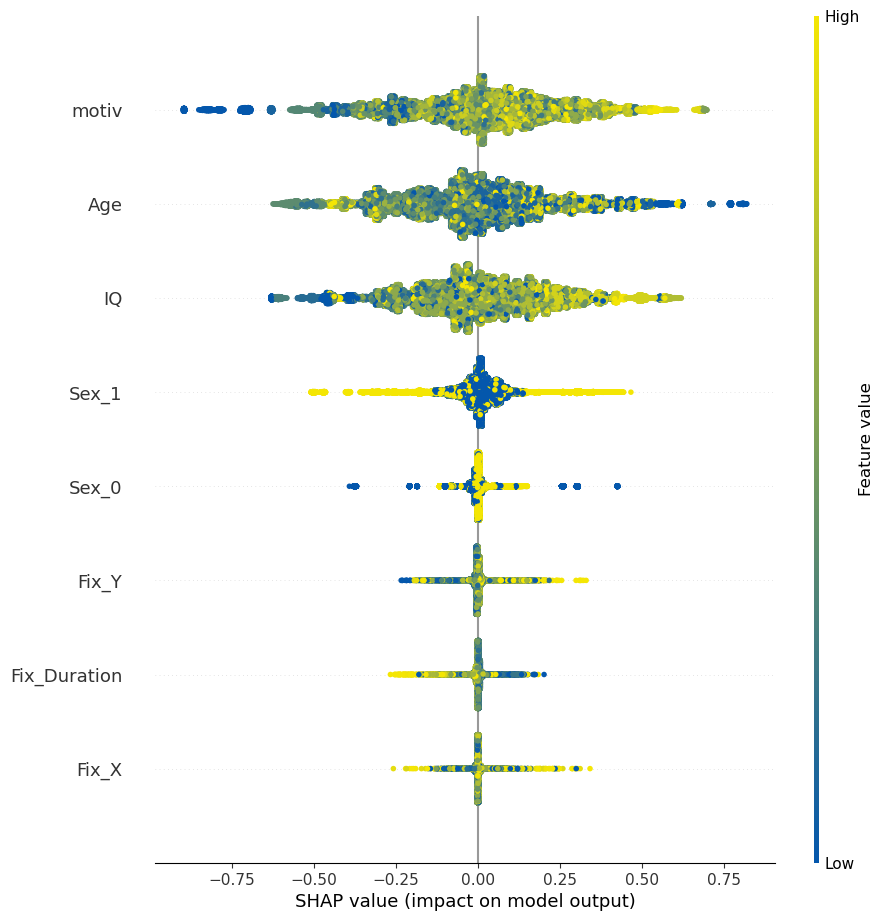

In [91]:


# Plot the summary without showing it
# plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
#                   class_inds="original", 
                  class_names=[0, 1, 2, 3],
                  max_display=46
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



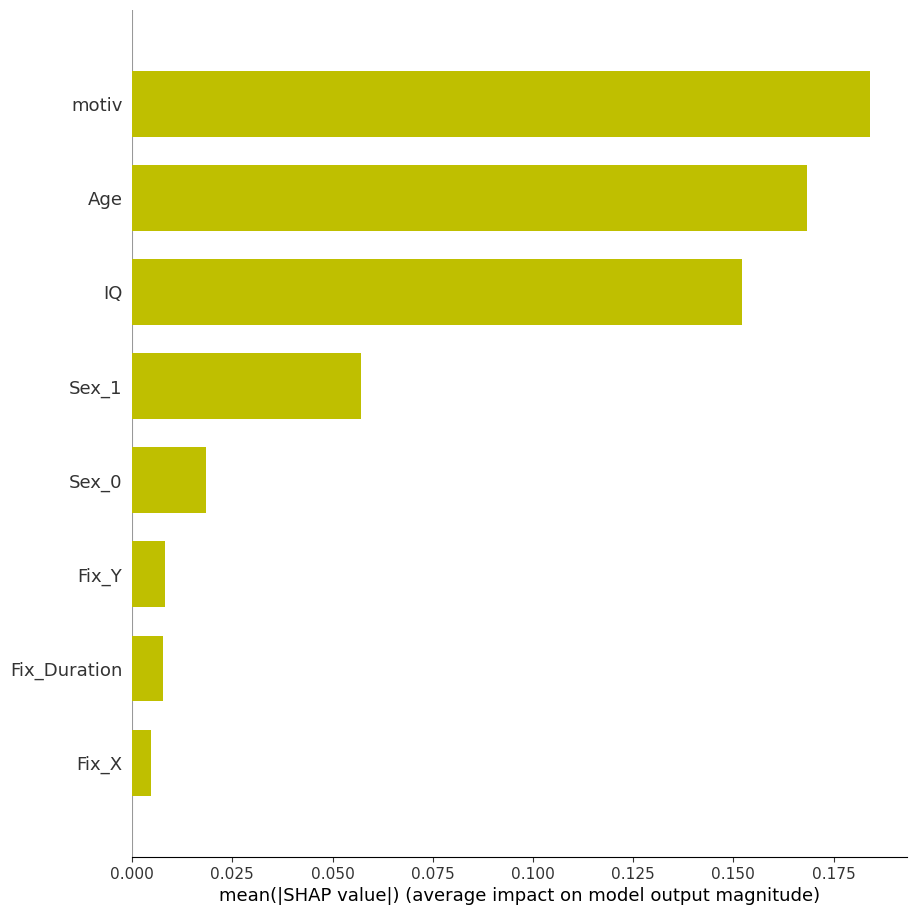

In [92]:


# plt.figure(figsize=(13, 10))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
                  plot_type="bar",
                  color='y', 
                  max_display=46

                 )


In [93]:

len(list(x_org.columns))




8

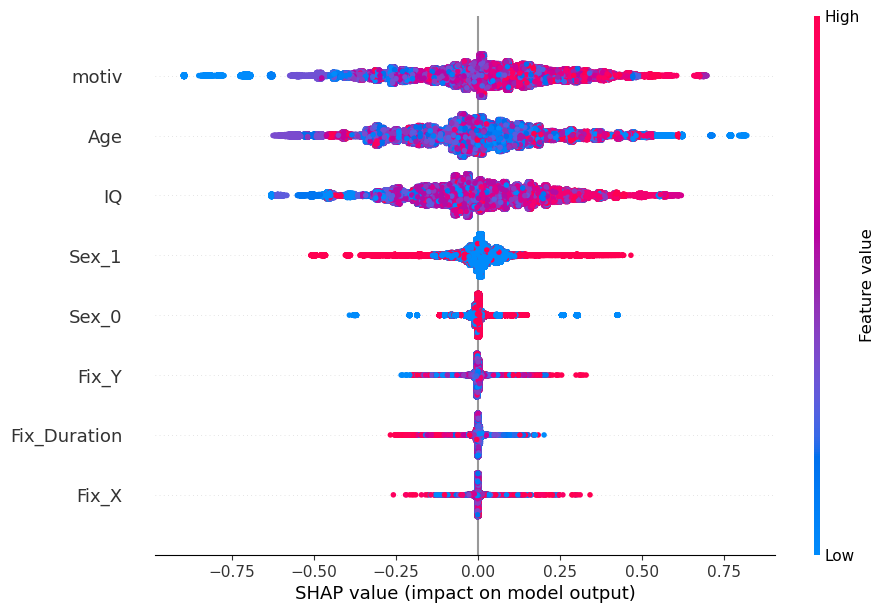

In [94]:
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
#                   class_names=class_names,
#                   plot_type="scatter"
                 )

# # Change the colormap of the artists
# for fc in plt.gcf().get_children():
#     for fcc in fc.get_children():
#         if hasattr(fcc, "set_cmap"):
#             fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



In [95]:


shap_values[0]



array([ 0.001,  0.001,  0.138, -0.001,  0.001, -0.018,  0.186,  0.167])

In [96]:


shap_values



array([[ 0.001,  0.001,  0.138, ..., -0.018,  0.186,  0.167],
       [ 0.001,  0.001,  0.138, ..., -0.017,  0.191,  0.164],
       [ 0.001,  0.001,  0.14 , ..., -0.017,  0.188,  0.166],
       ...,
       [ 0.002, -0.   , -0.046, ..., -0.079, -0.341, -0.318],
       [ 0.007, -0.   , -0.052, ..., -0.085, -0.311, -0.314],
       [-0.014, -0.   , -0.055, ..., -0.061, -0.354, -0.34 ]])

In [97]:


features = x_org.columns


In [98]:


mas_per_features = {}
for f in features:
    mas_per_features[f] = []
    



In [99]:


for f in range(len(features)): 
    tmp = np.mean(np.abs(shap_values[:, f]), axis=0)
#     print(f"{features[f]}:  {tmp:.3f}")
    mas_per_features[features[f]].append(tmp)
# print(" ")
    
    
    

In [100]:

sorted_mas_per_features = sorted(mas_per_features.items(), key=lambda x:x[1], reverse=True)
# sorted_mas_per_features



In [101]:
A = []

for k,v in sorted_mas_per_features:
#     b_ = (np.asarray(v).sum()*100/tot_)
    b_ = np.asarray(v).sum()

    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    A.append(np.asarray(v).sum())
    
    
    
    
    

Sum of MAS of motiv =  0.184  
Sum of MAS of Age =  0.168  
Sum of MAS of IQ =  0.152  
Sum of MAS of Sex_1 =  0.057  
Sum of MAS of Sex_0 =  0.019  
Sum of MAS of Fix_Y =  0.008  
Sum of MAS of Fix_Duration =  0.008  
Sum of MAS of Fix_X =  0.005  


In [1]:
0.019 +  0.057  

0.076

In [102]:
sum(A[:15])

0.6007398444791862

In [103]:
tot_ = sum(A)


for k,v in sorted_mas_per_features:
    b_ = (np.asarray(v).sum()*100/tot_)
    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    
    
    

Sum of MAS of motiv =  30.651  
Sum of MAS of Age =  28.012  
Sum of MAS of IQ =  25.345  
Sum of MAS of Sex_1 =  9.511  
Sum of MAS of Sex_0 =  3.086  
Sum of MAS of Fix_Y =  1.363  
Sum of MAS of Fix_Duration =  1.267  
Sum of MAS of Fix_X =  0.765  


In [2]:
30.651+28.012+25.345+9.511+3.086

96.60499999999999

In [105]:


for k, v in mas_per_features.items():
    print(
        f"Sum of MAS of {k} = {np.asarray(v)} "
    )
    
    
    

Sum of MAS of Fix_Duration = [0.008] 
Sum of MAS of Sex_0 = [0.019] 
Sum of MAS of IQ = [0.152] 
Sum of MAS of Fix_Y = [0.008] 
Sum of MAS of Fix_X = [0.005] 
Sum of MAS of Sex_1 = [0.057] 
Sum of MAS of Age = [0.168] 
Sum of MAS of motiv = [0.184] 
